# Table of Contents

In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import random

In [2]:
from matplotlib.font_manager import FontProperties
def image_samples(data, labels=None):
    
    font = FontProperties()
    font.set_family('monospace')
    
    plt.figure(figsize=(8,4))
    rows, cols = 2, 4 # these are arbitrary
    random_ids = random.sample(range(len(data)), rows*cols) # randomly select the images
    
    for i in range(rows*cols):

        curr_index = random_ids[i]
        image = data[curr_index]
        title_str = ('shape: ' + str(image.shape))
        
        if labels:
            title_str += ('\nclass ' + str(labels[i]))
        
        plt.subplot(rows, cols, i+1)
        plt.title(title_str, fontproperties=font)
        plt.imshow(image)
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Fetch Data

In [3]:
def get_train_images(data_path):
    
    raw_images = []
    labels = []

    for k in range(NUM_CLASSES):
        curr_dir_path = data_path + 'c' + str(k) + '/'

        for file in os.listdir(curr_dir_path):
            file_name = os.fsdecode(file)

            if file_name.endswith(".jpg"):
                file_path = (os.path.join(curr_dir_path, file_name))
                img = np.asarray(Image.open(file_path))#.flatten()
                raw_images.append(img)
                labels.append(k)
                
    return np.asarray(raw_images), np.asarray(labels)

In [4]:
def clean_data(data):
    
    # apply greyscale
    greyscale_imgs = data.mean(3) # dimension 3 of image shape corresponds to color channels
    
    # center-crop images
    cropped_imgs = greyscale_imgs[:, 50:480, 100:640]
    
    # print a sample of images
    image_samples(cropped_imgs)

    return cropped_imgs

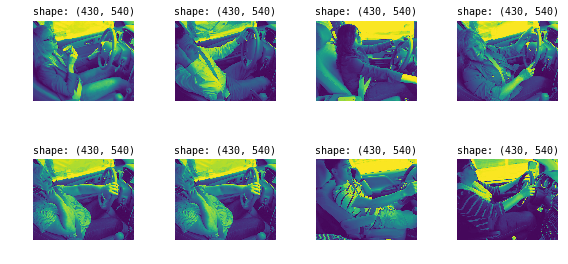

In [5]:
csv_path = '../dataset/driver_imgs_list.csv'
train_data_path = '../dataset/samples/'
# test_data_path = '../dataset/test/'

drivers_csv = pd.read_csv(csv_path)
classes = (np.unique(np.asarray(drivers_csv)[:,1]))
NUM_CLASSES = len(classes) # 10

# fetch images from stored dataset in path
raw_images, labels = get_train_images(train_data_path)

# apply gresycale
raw_images = clean_data(raw_images)
# print(raw_images.shape)

In [6]:
# From array to a picture
# img = Image.fromarray(arr)
# img.save("output.png")